In [1]:
import numpy as np
import pyscf
from pyscf import qmmm,scf,dft,gto
import matplotlib.pyplot as plt
import basis_set_exchange as bse
angstrom = 1 / 0.52917721067
import ipyvolume as ipv
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import cm
import pandas as pd

In [2]:
df=pd.read_pickle('data_def2_qzvpp')
df.query("ref=='HeMg'& target=='BeNe'& distance==2.0")

,alchemy,distance,basis_set,e_alch,e_ccsd,ref,target,abs_err,delta_rho,e_at_ref_bs,err_alch
835,0,2.0,def2-QZVPP,-130.683336,-143.184559,HeMg,BeNe,12.501222,6.502722,-142.398013,11.714677
836,1,2.0,def2-QZVPP,-141.653621,-143.184559,HeMg,BeNe,1.530937,6.502722,-142.398013,0.744392
837,2,2.0,def2-QZVPP,-142.419144,-143.184559,HeMg,BeNe,0.765414,6.502722,-142.398013,-0.021131
838,3,2.0,def2-QZVPP,-141.433436,-143.184559,HeMg,BeNe,1.751122,6.502722,-142.398013,0.964577
839,4,2.0,def2-QZVPP,-139.399012,-143.184559,HeMg,BeNe,3.785547,6.502722,-142.398013,2.999001


In [3]:
HAl=gto.Mole(atom='H 0 0 0 ; Al 2.0 0 0 ',unit='bohrs',basis='def2-QZVPP')
HeMg=gto.Mole(atom='He 0 0 0 ; Mg 2.0 0 0 ',unit='bohrs',basis='def2-QZVPP')
LiNa=gto.Mole(atom='Li 0 0 0 ; Na 2.0 0 0 ',unit='bohrs',basis='def2-QZVPP')

In [4]:
hf_hal=scf.RHF(HAl)
hf_lina=scf.RHF(LiNa)

Initialize <pyscf.gto.mole.Mole object at 0x7ff4108c9e48> in <pyscf.scf.hf.RHF object at 0x7ff4108c9b38>
Initialize <pyscf.gto.mole.Mole object at 0x7ff4108c9e80> in <pyscf.scf.hf.RHF object at 0x7ff4108c9b00>


In [5]:
Ehf_hal=hf_hal.scf()
print("energy HAl =" ,Ehf_hal)
Ehf_lina=hf_lina.scf()
print("energy LiNa =" ,Ehf_lina)

converged SCF energy = -242.294200319184
energy HAl = -242.29420031918374
converged SCF energy = -168.904368726622
energy LiNa = -168.90436872662173


In [6]:
def dm_ccsd(mol,ao):
    calc=scf.UHF(mol)
    includeonly = [0, 1]
    deltaZ=np.array((0.05,-0.05),dtype=float)*ao
    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords(), deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)
    mf = NoSelfQMMM()
    hfe=mf.kernel()
    mycc = pyscf.cc.CCSD(mf).set(frozen = 2,max_cycle=100).run()
    dm1 = mycc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff[0],dm1[0], mf.mo_coeff[0].conj())
    dm1_ao += np.einsum('pi,ij,qj->pq', mf.mo_coeff[1],dm1[1], mf.mo_coeff[1].conj())
    return dm1_ao

In [7]:
# E LiNa[HAl] 
calc=scf.RHF(HAl)
mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords(), np.asarray([2.,-2.],dtype=float))
class NoSelfQMMM(mf.__class__):
    def energy_nuc(self):
        q = self.mol.atom_charges().astype(np.float)
        q += np.asarray([2.,-2.],dtype=float)
        return self.mol.energy_nuc(q)
mf = NoSelfQMMM()
E_T_R=mf.kernel()

converged SCF energy = -168.700594107588


In [8]:
def e_alc_path(mol,dl):
    calc=scf.RHF(mol)
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords(), np.asarray([dl,-dl],dtype=float))
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float)
            q += np.asarray([dl,-dl],dtype=float)
            return self.mol.energy_nuc(q)
    mf = NoSelfQMMM()
    return mf.kernel(),mf.make_rdm1()

In [9]:
q=[]
for dl in np.linspace(.2,2.,10):
    q.append(e_alc_path(HAl,dl)[0])

converged SCF energy = -233.734296996794
converged SCF energy = -225.432930158949
converged SCF energy = -217.394887377089
converged SCF energy = -209.623993893621
converged SCF energy = -202.123121360053
converged SCF energy = -194.894204083358
converged SCF energy = -187.938201718079
converged SCF energy = -181.254992576284
converged SCF energy = -174.843275819639
converged SCF energy = -168.700594107588


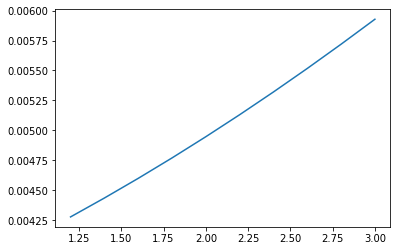

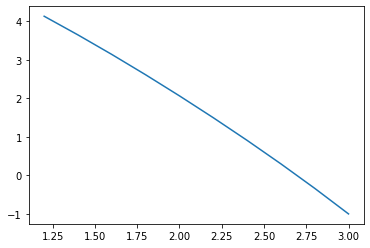

In [10]:
hch=np.linspace(.2,2.,10)+1.
plt.plot(hch,np.abs(np.asarray(q))**-1)
c1=2.2
c2=2.2
#plt.plot(hch,-hch**(c1)-(13-hch)**(c2))
plt.show()
plt.plot(hch,-np.asarray(q)-hch**(c1)-(13-hch)**(c2))

### Z1**[2.2]+Z2**2.2 approx well the Total energy

In [11]:
deriv=[]
for dl in [-.1,-.05,0.,.05,.1]:
    deriv.append(e_alc_path(HAl,dl)[0])

converged SCF energy = -246.669359007545
converged SCF energy = -244.473924318856
converged SCF energy = -242.294200319184
converged SCF energy = -240.130283420113
converged SCF energy = -237.98226731176


-4.375158688361097
-2.179723999672234
0.0
2.1639168990716087
4.3119330074237325


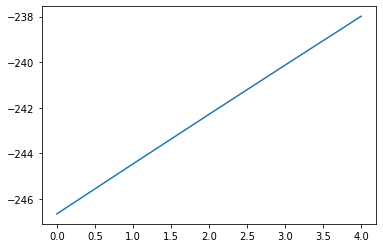

In [12]:
plt.plot(deriv)
for x in deriv:
    print(x-deriv[2])

In [13]:
def alc_pred5(ref_pts,dl,o=4):   
    dh=0.05
    coeff0=np.asarray([0,0,1.,0,0])
    coeff1=np.asarray([1/12,-2/3,0,2/3,-1/12])
    coeff2=np.asarray([-1/12 , 4/3 , -5/2 , 4/3 , -1/12])
    coeff3=np.asarray([-1/2 , 1 , 0 , -1 , 1/2])
    coeff4=np.asarray([1 ,-4 , 6 ,-4 , 1])
    coeff_list=[coeff1,coeff2,coeff3,coeff4]
    coeff_exp=coeff0.copy()
    for x in range(1,o+1):
        coeff_exp+=coeff_list[x-1]*(float(dl)/dh)**x/np.math.factorial(x)
    print (np.sum(ref_pts*coeff0),np.sum(ref_pts*coeff1),np.sum(ref_pts*coeff2),np.sum(ref_pts*coeff3),\
           np.sum(ref_pts*coeff4)) 
    return np.sum(ref_pts*coeff_exp)

In [14]:
def alc_pred7(ref_pts,dl,o=6,dh=0.05):   
    coeff0=np.asarray([0,0,0,1.,0,0,0],dtype=float)
    coeff1=np.asarray([-1/60,3/20,-3/4, 0, 3/4,-3/20,1/60],dtype=float)
    coeff2=np.asarray([1/90,-3/20,3/2,-49/18,3/2,-3/20,1/90],dtype=float)
    coeff3=np.asarray([1/8, -1, 13/8, 0, -13/8, 1, -1/8],dtype=float)
    coeff4=np.asarray([-1/6,2,-13/2,28/3,-13/2,2,-1/6],dtype=float)
    coeff5=np.asarray([-1/2,2,-5/2,0,5/2 ,-2,1/2],dtype=float)
    coeff6=np.asarray([1,-6,15,-20,15,-6,1],dtype=float)
    
    coeff_list=[coeff1,coeff2,coeff3,coeff4,coeff5,coeff6]
    coeff_exp=coeff0.copy()
    for x in range(1,o+1):
        coeff_exp+=coeff_list[x-1]*(float(dl)/dh)**x/np.math.factorial(x)
    
   # print (np.sum(ref_pts*coeff0),np.sum(ref_pts*coeff1),abs(np.sum(ref_pts*coeff2))**(1/2.),abs(np.sum(ref_pts*coeff3))**(1/3.),\
  #         abs(np.sum(ref_pts*coeff4))**(1/4.),abs(np.sum(ref_pts*coeff5))**(1/5.),abs(np.sum(ref_pts*coeff6))**(1/6.)) 
    return np.sum(ref_pts*coeff_exp)

In [28]:
dms=[]
for dl in [-.15,-.1,-.05,0.,0.05,0.1,0.15]:
    dms.append(e_alc_path(HAl,dl)[0])

converged SCF energy = -248.880405572223
converged SCF energy = -246.669359007545
converged SCF energy = -244.473924318857
converged SCF energy = -242.294200319184
converged SCF energy = -240.130283420113
converged SCF energy = -237.98226731176
converged SCF energy = -235.850242684843


In [29]:
for o in range (2,7):
    print((alc_pred7(dms,2.,dh=.05,o=o)))

-168.06661055990344
-169.08128357876558
-168.79024529550225
-168.53511713445187
-168.77458310127258


In [26]:
dms=[]
for dl in [1.85,1.9,1.95,2.0,2.05,2.1,2.15]:
    dms.append(e_alc_path(HAl,dl)[0])

converged SCF energy = -173.282502865262
converged SCF energy = -171.738500571412
converged SCF energy = -170.211216331715
converged SCF energy = -168.700594107588
converged SCF energy = -167.206574693957
converged SCF energy = -165.729095995568
converged SCF energy = -164.268093312437


In [27]:
for o in range (2,7):
    print((alc_pred7(dms,-2.,dh=.05,o=o)))

-242.07546330995888
-242.72314739754074
-242.414699325338
-242.1750158071518
-242.2269767522812
